In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from Python.tigre.algorithms.single_pass_algorithms import FDK

In [5]:
mydir = "C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda"

In [ ]:
geometry = 

In [6]:
def abs_diff(a,b):
    return np.abs(a-b)

def prct_diff(a,b):
    abs = abs_diff(a,b)
    return abs/(np.abs(a)+1e-6)

In [7]:
recon = np.load('./data/recon_sks2.npy',allow_pickle=True)


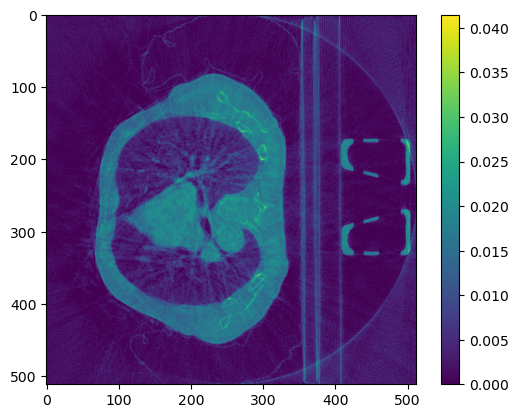

In [8]:
plt.imshow(recon[20])
plt.colorbar()

In [9]:
matfile=h5py.File('C:/CBCT_Scatter_Removal_Project/4100758_proj_recon.mat','r')
print(list(matfile.keys()))
matproj = np.array(matfile.get('proj_lg'))
matproj = np.squeeze(matproj)
matproj = np.transpose(matproj,axes=(0,2,1))
matfile.close()

['proj', 'proj_dps', 'proj_lg', 'recon']


In [10]:
matrec = FDK(matproj,geometry,angles,verbose=True
             )

NameError: name 'geometry' is not defined

In [35]:
matrec[matrec<0]=0
recon[recon<0]=0

In [40]:
from Python.tigre.utilities.mask_CBCT import maskCBCT

In [43]:
abs = abs_diff(maskCBCT(matrec),maskCBCT(recon))
np.mean(abs)

0.00014697755

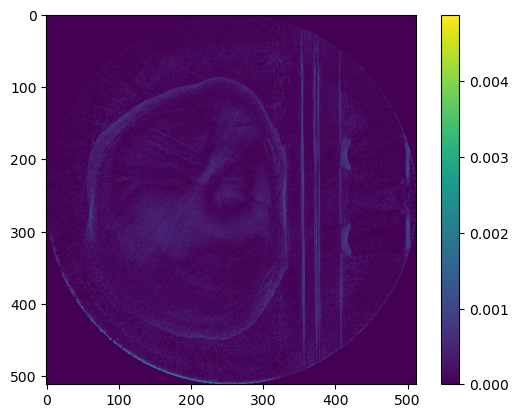

In [45]:
plt.imshow(abs[44])
plt.colorbar()